# Lab 02: Credit Ratings

---
author: Brady Brooks
date: September 13, 2024
embed-resources: true
---

## Introduction

In this report, we deveop a model to estimate the credit scores of new customers for a small bank. For years, our bank relied on credit agencies to provide a rating, but that costs money. We believe we could reverse engineer the credit ratings with the ones we already puchased. We know the demographics, income, and education of our customers. Overall, the model is used to predict the credit ratings of the new customers.

## Methods

In [50]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import warnings

### Data

In [51]:
# load data
credit_train = pd.read_csv("https://cs307.org/lab-02/data/credit-train.csv")
credit_test = pd.read_csv("https://cs307.org/lab-02/data/credit-test.csv")
credit_train

,Rating,Income,Age,Education,Gender,Student,Married,Ethnicity
0,257.0,44.473,81.0,16.0,Female,No,No,NaN
1,353.0,41.532,50.0,NaN,Male,No,Yes,Caucasian
2,388.0,16.479,26.0,16.0,Male,NaN,No,NaN
3,321.0,10.793,29.0,13.0,Male,No,No,Caucasian
4,367.0,76.273,65.0,14.0,Female,No,Yes,Caucasian
...,...,...,...,...,...,...,...,...
251,268.0,26.370,78.0,11.0,Male,No,Yes,Asian
252,433.0,26.427,50.0,15.0,Female,Yes,Yes,Asian
253,259.0,12.031,58.0,18.0,Female,NaN,Yes,Caucasian
254,335.0,80.861,29.0,15.0,Female,No,Yes,Asian


In [52]:
# create X and y for train
X_train = credit_train.drop("Rating", axis=1)
y_train = credit_train["Rating"]

# create X and y for test
X_test = credit_test.drop("Rating", axis=1)
y_test = credit_test["Rating"]

The train data contains the previously puchased credit ratings of our customers and some information about the customer to predict the rating. The test data is the same.

#### Response
Rating
-   [float65] credit score of the customer

#### Featuress
Income
-   [float64] Annual income of the customer

Age
-   [float64] Age in years

Education
-   [float64] Numbers 0-20 based on how many years of education the customer did

Gender
-   [object] Gender of the customer between Male and Female

Student
-   [object] Whether or not the customer is a student

Married
-   [oobject] Whether or not the customer is married

Ethnicity
-   [object] Ethnicity of the customer

In [53]:
# summary statistics
print(y_train.mean())
print(y_train.std())

347.609375
148.8931046679028


The mean of the credit ratings are around 347 and the standard deviation is nearly 150 which is very large.

In [54]:
no_train = credit_train[credit_train["Student"] == "No"]
yes_train = credit_train[credit_train["Student"] == "Yes"]
no_mean = no_train["Rating"].mean()
no_std = no_train["Rating"].std()
no_count = no_train.shape[0]
yes_mean = yes_train["Rating"].mean()
yes_std = yes_train["Rating"].std()
yes_count = yes_train.shape[0]
print(f"Students Status- No Mean: {no_mean} No Std: {no_std} No Count {no_count}")
print(f"Student Status- Yes Mean: {yes_mean} Yes Std: {yes_std} Yes Count {yes_count}")

Students Status- No Mean: 349.51173708920186 No Std: 148.00352527445554 No Count 213
Student Status- Yes Mean: 338.4736842105263 Yes Std: 149.1644761183859 Yes Count 19


In [55]:
no_train = credit_train[credit_train["Married"] == "No"]
yes_train = credit_train[credit_train["Married"] == "Yes"]
no_mean = no_train["Rating"].mean()
no_std = no_train["Rating"].std()
no_count = no_train.shape[0]
yes_mean = yes_train["Rating"].mean()
yes_std = yes_train["Rating"].std()
yes_count = yes_train.shape[0]
print(f"Married Status- No Mean: {no_mean} No Std: {no_std} No Count {no_count}")
print(f"Married Status- Yes Mean: {yes_mean} Yes Std: {yes_std} Yes Count {yes_count}")

Married Status- No Mean: 329.3979591836735 No Std: 132.03964882478107 No Count 98
Married Status- Yes Mean: 358.90506329113924 Yes Std: 157.7979352901777 Yes Count 158


In [56]:
temp = credit_train[["Age", "Income", "Rating"]]
temp.corr()

,Age,Income,Rating
Age,1.000000,0.202098,0.143032
Income,0.202098,1.000000,0.770842
Rating,0.143032,0.770842,1.000000


In [57]:
credit_train.isna().sum()/credit_train.shape[0]

Rating       0.000000
Income       0.000000
Age          0.128906
Education    0.097656
Gender       0.023438
Student      0.093750
Married      0.000000
Ethnicity    0.097656
dtype: float64

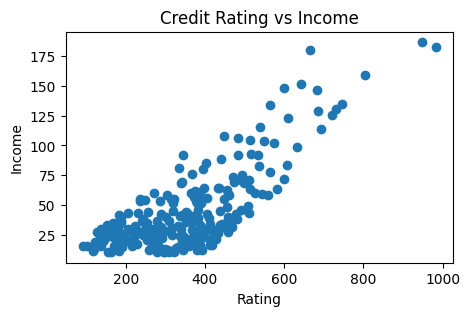

In [58]:
# visualizations
plt.figure(figsize=(5,3))
plt.scatter(credit_train["Rating"], credit_train["Income"])
plt.xlabel('Rating')
plt.ylabel("Income")
plt.title("Credit Rating vs Income")
plt.show()

As seen in the plot, we can see that having a higher income is highly correlated with a customers credit rating. The higher their income, the more likely they'll have a higher credit rating.

### Models

In [59]:
# process data for ML
# note numeric and categorical features
numeric_features = ["Income", "Age"]
categorical_features = ["Education", "Gender", "Student"]

# define preprocessing for numeric features
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
    ]
)

# define preprocessing for categorical features
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

# combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# create pipeline, preprocess then classify
pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", KNeighborsRegressor()),
    ]
)

In [60]:
param_grid = {
    "preprocessor__cat__onehot__drop": [None, 'first'],
    "regressor__n_neighbors": range(1, 30, 2),
    "regressor__metric": ["euclidean", "manhattan"],
}

In [61]:
# train models
warnings.filterwarnings("ignore")
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring="neg_root_mean_squared_error")
mod = grid_search.fit(X_train, y_train)

For the model, I first made a pipeline to fill in empty values and chose to use the model KNeighborsRegressor. After countless tuning attempts with the features, I ended up removing a few of them and moved "Education" to categorical. To fill the empty values, I replaced the categorical ones with the most frequent entry of that column and the numerical ones I replaced with the mean of that feature. I then created a grid which takes in every other number between 1-30 (exclusive) as k. It also checks euclidean and manhattan distance to find the nearest neighbors. Finally, I made and fit the model with a cross validation of 5 and made it test for root mean squared error (RMSE).

## Results

In [62]:
y_pred = mod.predict(X_test)
print(f"Test set accuracy: {root_mean_squared_error(y_test, y_pred)}")

Test set accuracy: 109.58590696762592


After tuning the features and the parameters, the model achieves a RMSE of 109.58590696762592.

## Discussion

With an RMSE of just under 110, this model is of limited use.

Given that the credit rating range is between 0-1000, this model is likely not worth using over paying the credit agencies to provide us with customers credit ratings. To use my model to make big decisions at the bank like whether or not to give a customer a loan wouldn't be worth it. This model could be improved if we had more information about their credit history. We are only using some demographics and their income to predict so if we had more correlated features that could improve our model. In addition, we could have also tried removing the samples with incomplete data instead of filling them in. Overall, the model could be improved and isn't accurate enough to make big decisions at the bank.

### Conclusion

Given the high inaccuracy of the model, I do not recommend the use of this model in practice at this time.

In [63]:
# report model metrics
from joblib import dump
dump(mod, "credit-ratings.joblib")

['credit-ratings.joblib']